# STAT301 Project - Final Report
## Dec 5, 2025
## Group 23

### Sarah Chan 56278500, Zewen Jin 71642011, Bryan Sun 39325758, Lucas Ortiz Molina 82509779

## **1 Introduction**
Online shopping is growing more rapidly than ever before. Understanding the behavioural patterns that lead customers to complete a purchase has become more important for online retailers. The Online Shoppers Purchasing Intention dataset provides information about users browsing behaviour, including the types of pages visited, the amount of time spent on each page category, session characteristics, and contextual variables such as proximity to special days. These signals can help build predictive models that estimate the likelihood a customer will complete a transaction during a browsing session. Our objective is to develop models that can accurately predict the probability that a session results in a purchase (Revenue). Our primary focus is prediction, so we aim to identify which session characteristics produce strong predictive power in estimating purchasing likelihood of users. 

### **1.1 Scientific Question**
We want to examine how well session timing and product related browsing duration can help predict whether a user ultimately makes a purchase.

To answer this question, the model would have variables of interests as below:
- response:`Revenue`
- covariates: `Weekend`, `Month`, `ProductRelated_Duration`

This question is focused on prediction, as we are exploring how session time and duration of visits to product-related pages can predict the likelihood of making a purchase

## **2 Methods and Results**

### **2.1 Data**

#### 2.1.1 Summary of data

The dataset records sessions of online shoppers, where each session belongs to a different user in a 1-year period. There are a total of 12330 sessions (observations) and 18 variables, which are described below:

- `Administrative` (Integer): the number of administrative pages the user visited during a session
- `Administrative_Duration`	(Integer): the total time spent on administrative pages during a session	
- `Informational`	(Integer): the number of informative pages the user visited during a session
- `Informational_Duration`	(Integer): the total time spent on informative pages during a session		
- `ProductRelated`	(Integer): the number of product-related pages the user visited during a session
- `ProductRelated_Duration`	(Continuous): the total time spent on product-related pages during a session	

Note: The values of the above features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. **The unit time for the durations are not given**.

- `BounceRates`	(Continuous): the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session
- `ExitRates`	(Continuous): for all pageviews to a specific page, the percentage of the pageviews that were the last in the session
- `PageValues`	(Integer): the average value for a web page that a user visited before completing an e-commerce transaction
- `SpecialDay`	(Integer): the closeness of the site visiting time to a specific special day, determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date
- `Month`	(Categorical): the month in which the session occurred 
- `OperatingSystems`	(Integer): the type of operating system used for the session (probably encoded into integers here)
- `Browser`	(Integer): the type of browser used for the session (probably encoded into integers here)
- `Region`	(Integer): the region in which the session occurred (probably encoded into integers here)
- `TrafficType`	(Integer): the type of traffic used during the session (probably encoded into integers here)
- `VisitorType`	(Categorical): type of visitor for a page, either a returning (`Returning_visitor`) or new (`New_visitor`)
- `Weekend`	(Binary): whether or not the date of visit to a page is on a weekend	
- `Revenue`	(Binary): whether or not revenue is made, ie. if the user made a purchase	

As shown below, there are **no missing values** in the dataset.

**No data from region 1 will be used, as instructed.**

#### 2.1.2 Source of data

The dataset is obtained from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset). The data is obtained from website analytics tools, such as Google Analytics and more, collecting number of page visits, duration of visits, type of visitor, etc. These data are observational

### **2.2 Exploratory Data Analysis**

The dataset is loaded in using `read.csv()` and the excluded variables are removed first using `select()`. 

The data type is checked, and I also checked if there are any missing values.

<!-- install.packages("ggpubr")
install.packages("corrplot")
install.packages("broom")
install.packages("car") -->

In [1]:
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggpubr, warn.conflicts = FALSE)
library(corrplot, warn.conflicts = FALSE)
library(car, warn.conflicts = FALSE)
library(broom, warn.conflicts = FALSE)
library(rsample, warn.conflicts = FALSE)
library(caret, warn.conflicts = FALSE)
library(glmnet, warn.conflicts = FALSE)
library(pROC, warn.conflicts = FALSE)

corrplot 0.95 loaded

Loading required package: carData

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-10

Type 'citation("pROC")' for a citation.



In [2]:
data <- read.csv("https://raw.githubusercontent.com/schan26/stat301-project/refs/heads/main/data/online_shoppers_intention.csv")

data <- data %>% filter(Region != 1) # Use data not from Region 1

# Change categorical variables to factor type
data$Month <- as.factor(data$Month)
data$VisitorType <- as.factor(data$VisitorType)
data$OperatingSystems <- as.factor(data$OperatingSystems)
data$Browser <- as.factor(data$Browser)
data$Region <- as.factor(data$Region)
data$TrafficType <- as.factor(data$TrafficType)

# check data type of each variable
sapply(data, class)

# check for missing values count in data frame
sum(is.na(data))

nrow(data)

Administrative Administrative_Duration           Informational 
              "integer"               "numeric"               "integer" 
 Informational_Duration          ProductRelated ProductRelated_Duration 
              "numeric"               "integer"               "numeric" 
            BounceRates               ExitRates              PageValues 
              "numeric"               "numeric"               "numeric" 
             SpecialDay                   Month        OperatingSystems 
              "numeric"                "factor"                "factor" 
                Browser                  Region             TrafficType 
               "factor"                "factor"                "factor" 
            VisitorType                 Weekend                 Revenue 
               "factor"               "logical"               "logical"

[1] 0

[1] 7550

<!--->

After removing data from Region 1, there are a total of 7550 observations left in the dataset. 

We fixed the data types, and no missing values are present in the training dataset.

In [3]:
# Exploring class balance
data %>%
  summarize(count = mean(Revenue)) 

count
<dbl>
0.150596


We can observe a **severe class imbalance** in `Revenue`, with `Revenue` = 1 as the minority class (this is also the positive class). This is expected since many shoppers simply browse but not make a purhase in the end. 

To account for this, we would use AUC as the scoring metric during model selection. However, results may still not be ideal.

We split the dataset into training and testing set using a 70-30 split. EDA and fitting will be done on training set, and the test set is not peaked at until final assess of model performance.

In [4]:
set.seed(42)

# Split data into train and test set
data_split <- data %>% initial_split(prop = 0.7, strata = Revenue)
training <- training(data_split)
testing <- testing(data_split) # Used only after all EDA and fitting

head(training)
nrow(training)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,0,0,0,0,2,2.666667,0.050000000,0.14000000,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
2,0,0,0,0,1,0.000000,0.200000000,0.20000000,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE
3,0,0,0,0,2,37.000000,0.000000000,0.10000000,0,0.8,Feb,2,2,2,3,Returning_Visitor,FALSE,FALSE
4,0,0,0,0,2,68.000000,0.000000000,0.10000000,0,0.0,Feb,3,2,3,3,Returning_Visitor,FALSE,FALSE
5,2,53,0,0,23,1668.285119,0.008333333,0.01631264,0,0.0,Feb,1,1,9,3,Returning_Visitor,FALSE,FALSE
6,0,0,0,0,1,0.000000,0.200000000,0.20000000,0,0.0,Feb,1,1,4,3,Returning_Visitor,FALSE,FALSE


[1] 5284

Here are the summary statistics for each variables:

In [5]:
summary(training)
# count of observations for each category for the categorical variables
training %>% count(Month)
training %>% count(VisitorType)
training %>% count(Browser)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  11.00         Median : 0.0000  
 Mean   : 2.357   Mean   :  83.27         Mean   : 0.4595  
 3rd Qu.: 4.000   3rd Qu.:  98.42         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
                                                           
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  187.7        
 Median :   0.00        Median : 18.00   Median :  598.8        
 Mean   :  32.42        Mean   : 30.53   Mean   : 1148.4        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1462.0        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
                                                                


Month,n
<fct>,<int>
Aug,190
Dec,784
Feb,74
Jul,197
June,134
Mar,791
May,1510
Nov,1176
Oct,226


VisitorType,n
<fct>,<int>
New_Visitor,726
Other,49
Returning_Visitor,4509


Browser,n
<fct>,<int>
1,976
2,3439
3,40
4,339
5,210
6,72
7,24
8,64
9,1


Interestingly, there are no sessions recorded in January or April.

There are also another type of visitor that is not included in data description values.

For `Browser`, there are some levels that have very little observations. We will see if this is an issue when we fit models in the next section.

There could be extreme outliers for the duration of page visits (`Administrative_Duration`, `Informational_Duration`,`ProductRelated_Duration`), seen by comparing the median and the max of these variables

`summarise()` has grouped output by 'Month'. You can override using the `.groups` argument.


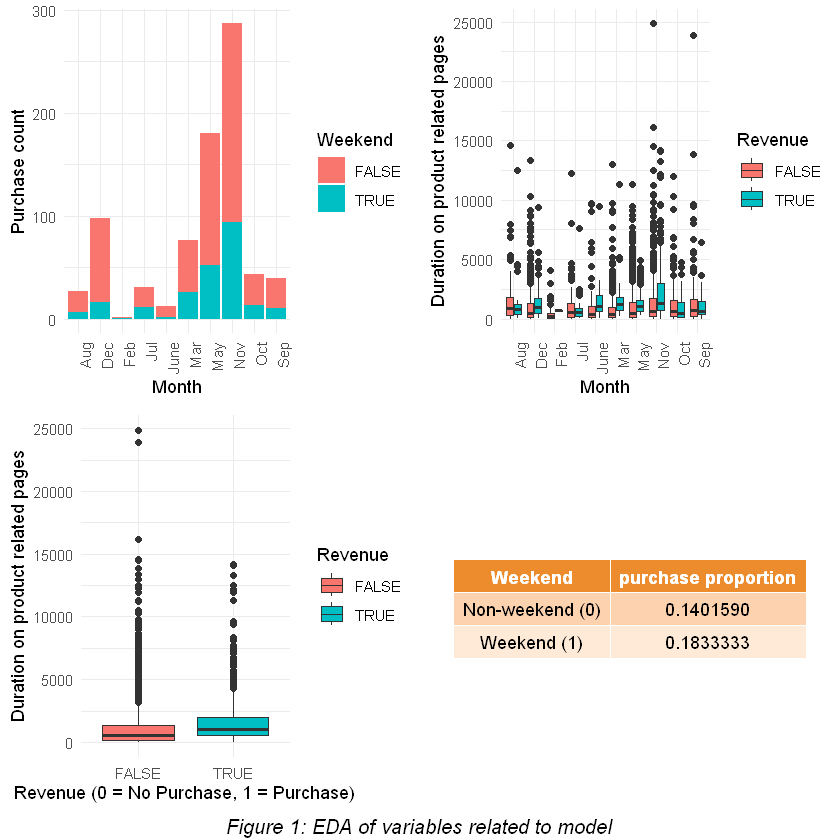

In [6]:
# Plot of Revenue against Month and ProductRelated_Duration
rev_month_dur <- ggplot(training, aes(x = Month, y = ProductRelated_Duration)) +
  geom_boxplot(aes(fill = Revenue)) +
  labs(
    x = "Month",
    y = "Duration on product related pages"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Plot of Revenue against Month and Weekend
rev_month_we_sum <- training %>%
  group_by(Month, Weekend) %>%
  summarize(count = sum(Revenue)) 

rev_month_we <- ggplot(rev_month_we_sum, aes(x = Month, y = count, fill=Weekend)) +
  geom_bar(stat="identity",position="stack") +
  labs(
    x = "Month",
    y = "Purchase count",
  ) +
  theme_minimal()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) 

# Table of Revenue against Weekend using proportion of successful purchases
weekend_sum <- training %>%
  group_by(Weekend) %>%
  summarize("purchase proportion" = mean(Revenue)) %>%
  mutate(Weekend = if_else(Weekend == 0, "Non-weekend (0)", "Weekend (1)"))
weekend_table <- ggtexttable(weekend_sum, rows = NULL, 
                        theme = ttheme("mOrange"))


# Plot of Revenue against ProductRelated_Duration
rev_dur <- ggplot(training, aes(x = Revenue, y = ProductRelated_Duration)) +
  geom_boxplot(aes(fill=Revenue)) +
  labs(
    x = "Revenue (0 = No Purchase, 1 = Purchase)",
    y = "Duration on product related pages",
  ) +
  theme_minimal()

# combine above plots into one plot using ggarrange from ggpubr library
plot <- ggarrange(rev_month_we, rev_month_dur, rev_dur,  weekend_table , 
          ncol = 2, nrow = 2)
annotate_figure(plot,
                bottom = text_grob("Figure 1: EDA of variables related to model", 
                                   color = "black", face = "italic", size = 12))

*Remark: I used proportion of purchases for visualizing the relationship between `Weekend` and `Revenue` because there are imbalance of number of days for weekend and non-weekend (2 days and 5 days respectively, which would give misleading results if I simply plot the raw counts).*

From *Figure 1*:

- We believe this plot is relevant to our question because it shows exploration of the potential relationships between the covariates (or interaction of covariates) and the response variable. Visualizing the variables could help with making an initial identification of which covariates are associated with probability of making a purchase.
- The first plot in the figure shows that the number of purchases in December, March, May, and November is much higher compared to other months. In addition, the second plot shows that the duration on product-related pages for succussful purchases is noticeably higher in November and March compared to other months. Therefore, these two plots suggests that the probability of making a purchase could  vary across each month.
- Plot 3 (bottom left) suggests that the probability of purchase is associated with the time spent on product-related pages, sinc the plot shows a difference in means of duration on the page between session that resulted in a purchase (`Revenue`=1) or not (`Revenue`=0).
- From the visualization, we can see that there are extreme outliers for `ProductRelated_Duration`, which could impair our model as these could greatly influence the linear model. Moreover, there is very little data for the revenue count in February, so the predictions in the model for February may be unreliable.
- From the table in *Figure 1*, The proportion of successful purchase between a Weekend session and Non-weekend session are quite similar, suggesting that `Weekend` may not be a strong predictor of `Revenue`.

Figure 2: Correlation plot of the features

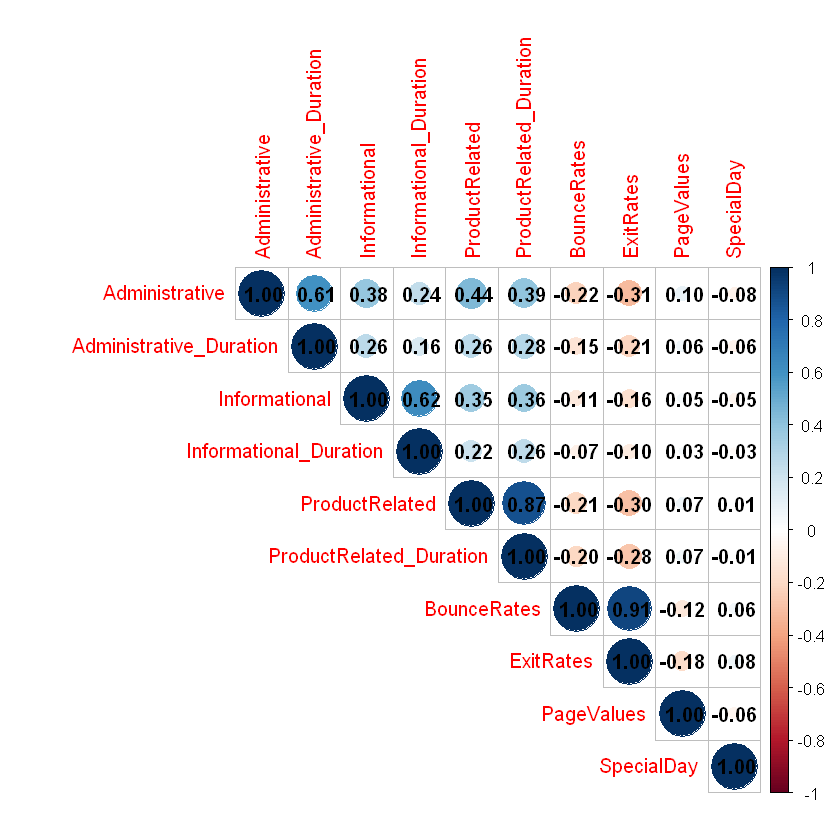

In [7]:
# plotting the correlation plot for numeric variables
numeric_data <- training[sapply(training, is.numeric)]
cor_mat <- cor(numeric_data, use = "complete.obs")

corrplot(cor_mat,
         type = "upper",       
         addCoef.col = "black" 
)
cat("Figure 2: Correlation plot of the features")

From *Figure 2*, it can be seen that `Informational` and `Informational_Duration`, `Administrative` and `Administrative_Duration`, all have a very high correlation. These pairs of features may lead to multicollinearity issues during model fitting.

### **2.3 Methods: Plan**

We will use **logistic regression** because our research question is about predicting if an online purchase is done. The repsonse variable `Revenue` is a binary variable, so this method is appropraiate for this context since it can map probability of successful online purchases to binary outcomes, and the probability is dependent on session features. 

**Assumptions**: 
Logistic regression assumes that the observations are independent, the response is binary, and that the log-odds of online purchases has a linear relationship with the session features. It also assumes that there is no multicollinearity issue between the covariates. 

**Limitations**:
This model cannot capture non-linear relationships between log-odds of online purchases and session features unless data transformation or interaction terms is introduced. It is also sensitive to outliers. In addition, if the observations are not independent or multicollinearity is present, predictions would be unstable and there would be risk of overfitting.

**Methods**:
Using the training set, we tried fitting three models: ordinary, LASSO, and ridge logistic regression (LR) model. For the ordinary LR, we checked the VIF and correlation plot to select variables. For LASSO and ridge LR, we used a 10-fold cross validation, optimizing for AUC, to select our best model. A final model is then chosen based on AUC from ROC curve due to class imbalance issues, and we want to focus more on predicitng the positive class (making a purchase) correctly. Lastly, the final model performance is evaluated using the test set.

### **2.4 Computational Code and Results**

#### **2.4.1 Preliminary Model**

For an initial model, I will fit an ordinary logistic regression model with all session features.

Potential correlated numeric covariates is first explored, I will use 0.6 as a threshold for indicating strong correlation:

Referring back to *Figure 2* in *Section 2.2 EDA*, `BounceRates` and `ExitRates`, `ProductRelated` and `ProductRelated_Duration`, `Informational` and `Informational_Duration`, `Administrative` and `Administrative_Duration` have a correlation over 0.6. 

Therefore, I would remove the features `BounceRates` since it's less informative than `ExitRates` (reflects end-of-session behavior of shoppers), and `ProductRelated`, `Informational`, `Administrative` as these variables are counts of pages visited, which is provides less detailed information than time spent on those type of pages.  

The model is then fitted on the remaining variables and multicollinearity issues is checked.

In [8]:
# Remove the correlated variables
uncor_training <- training %>% select(-BounceRates, -ProductRelated, -Informational, -Administrative)

In [9]:
# fit 1st model
model <- glm(Revenue ~ ., uncor_training, family = "binomial")

# check vif for multicollinearity issue (ran into error about aliased coefficients, so checking alias instead)
alias(model)

Model :
Revenue ~ Administrative_Duration + Informational_Duration + 
    ProductRelated_Duration + ExitRates + PageValues + SpecialDay + 
    Month + OperatingSystems + Browser + Region + TrafficType + 
    VisitorType + Weekend

Complete :
          (Intercept) Administrative_Duration Informational_Duration
Browser11 0           0                       0                     
          ProductRelated_Duration ExitRates PageValues SpecialDay MonthDec
Browser11 0                       0         0          0          0       
          MonthFeb MonthJul MonthJune MonthMar MonthMay MonthNov MonthOct
Browser11 0        0        0         0        0        0        0       
          MonthSep OperatingSystems2 OperatingSystems3 OperatingSystems4
Browser11 0        0                 0                 0                
          OperatingSystems5 OperatingSystems6 OperatingSystems7
Browser11 1                 0                 0                
          OperatingSystems8 Browser2 Browser3 Br

As above, there are levels of `Browser` that is aliased with other covariates, which implies perfect multicollinearity with some other covariates. This could be due to some levels of `Browser` having little observations as noted in Section 2.2. Therefore, we decided to drop this variable in the model.

In [10]:
uncor_training <- uncor_training %>% dplyr::select(-Browser)

model <- glm(Revenue ~ ., uncor_training, family = "binomial")

# check vif for multicollinearity issue
 car::vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
Administrative_Duration,1.133513,1,1.064666
Informational_Duration,1.103109,1,1.050290
ProductRelated_Duration,1.307619,1,1.143512
ExitRates,1.179350,1,1.085979
PageValues,1.092075,1,1.045024
SpecialDay,1.227012,1,1.107706
Month,1.881983,9,1.035754
OperatingSystems,2.335673,7,1.062466
Region,1.181771,7,1.012001
TrafficType,2.210841,17,1.023609


There are no issues now! The VIF of each variable is less than 5, so there is **no** sign of multicollinearity issues. This model would be our preliminary prediction model.

#### **2.4.2 Model Selection Using LASSO and RIDGE**

We will now train our LASSO and ridge models using cross validation:

In [11]:
# Preparing X and y matrix for glmnet
model_X_train <- model.matrix(Revenue ~ ., data = training)[,-1]
matrix_Y_train <- as.matrix(training$Revenue, ncol=1)

In [12]:
set.seed(42)

# Perform 10-fold CV using LASSO, optimizing for AUC
lasso <- 
  cv.glmnet(
  x = model_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

# Perform 10-fold CV using Ridge, optimizing for AUC
ridge <- 
  cv.glmnet(
  x = model_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

lasso
ridge


Call:  cv.glmnet(x = model_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.04041    17  0.9114 0.00683       3
1se 0.04041    17  0.9114 0.00683       3


Call:  cv.glmnet(x = model_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.01790   100  0.8930 0.005951      65
1se 0.07932    84  0.8873 0.005702      65

From the above table, we can see that the best model has an AUC of 0.9114 for LASSO and AUC of 0.8930 for ridge. In the model wtih LASSO, only 3 variables are selected, and the model with ridge did not remove any variables.

Interestingly, $\lambda_{min}$ and $\lambda_{1se}$ are the same for LASSO model. This means that the largest $\lambda$ such that the AUC is within 1 standard error from the highest AUC is selected to be the same value. In other words, our AUC curve does not change much near the maximum point.

We visualized the AUC for different $\lambda$ below, and can see that our AUC curve is quite flat for the LASSO model.

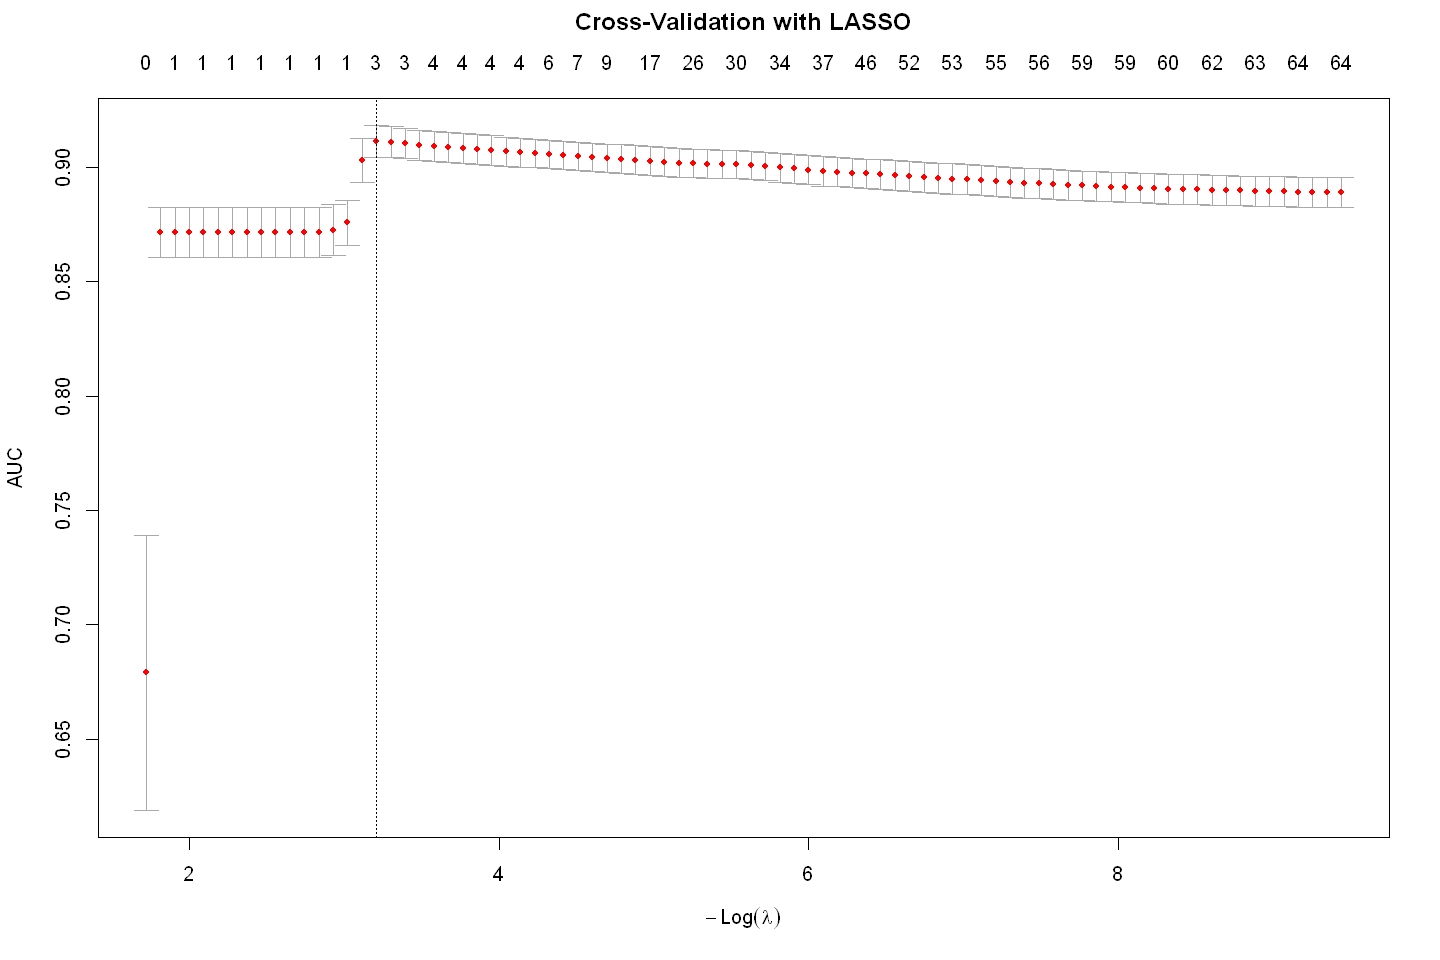

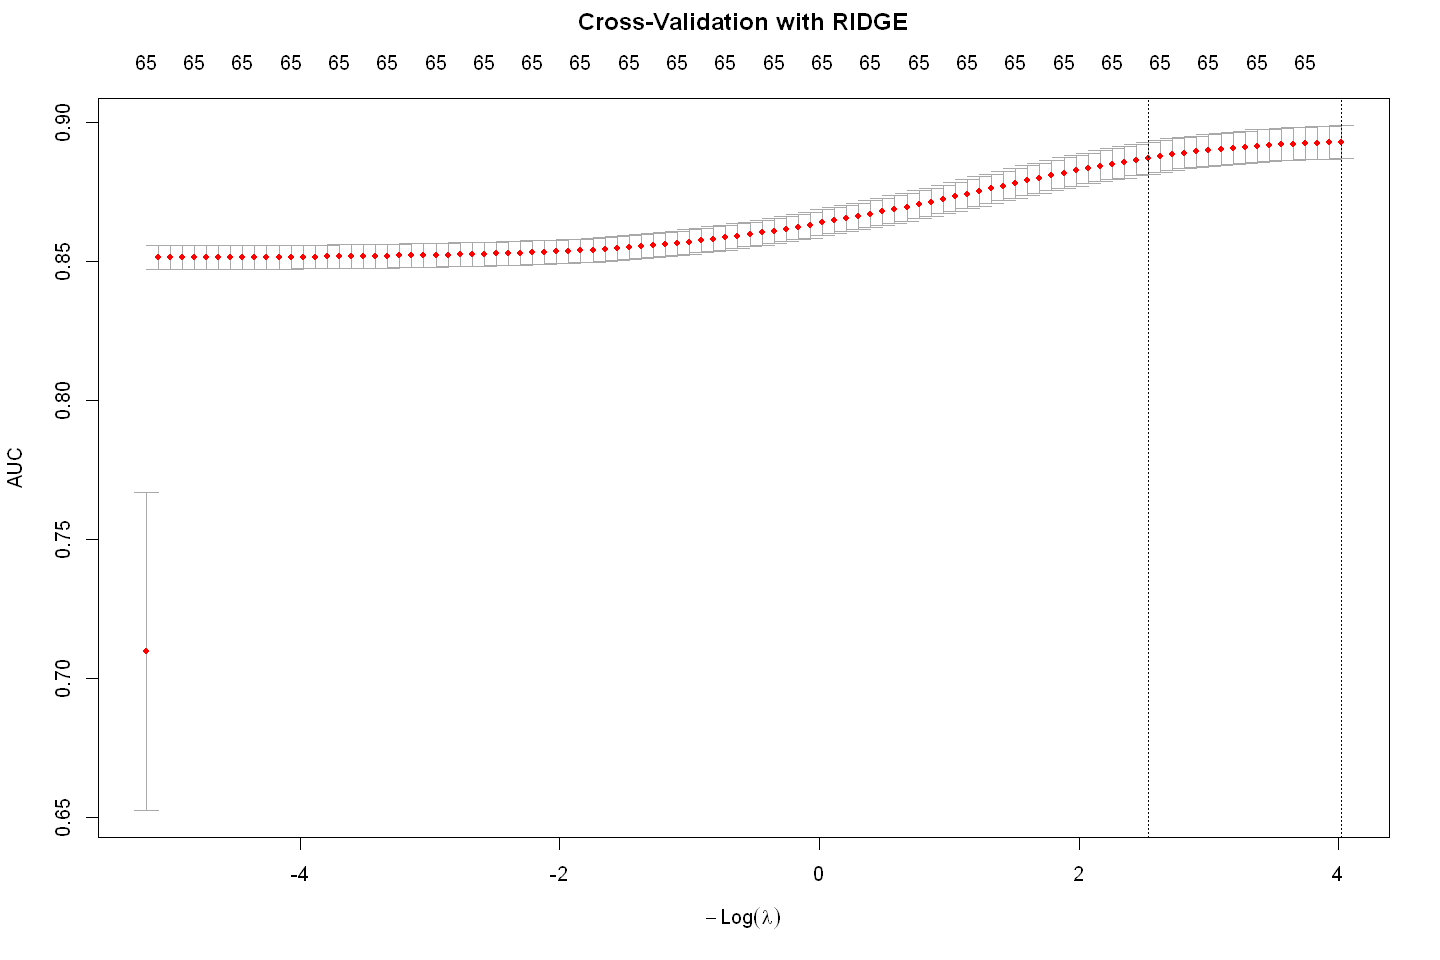

In [13]:
options(repr.plot.width = 12, repr.plot.height = 8)

plot(lasso, main = "Cross-Validation with LASSO\n\n")
plot(ridge, main = "Cross-Validation with RIDGE\n\n")

In [14]:
# Extract best lambda that maximizes AUC
lambda_max_AUC_lasso <- round(lasso$lambda.min, 4)
lambda_max_AUC_ridge <- round(ridge$lambda.min, 4)

lambda_max_AUC_lasso
lambda_max_AUC_ridge

[1] 0.0404

[1] 0.0179

Reporting the $\lambda$ chosen that maximizes AUC:
- LASSO: $\lambda = 0.0404$
- ridge: $\lambda = 0.0.0179$

Now, let's obtain our models with the tuned hyperparameter:

In [15]:
# Obtaining our best model using the best lambda
final_lasso <- glmnet(
  x = model_X_train,
  y = as.numeric(training$Revenue),
  alpha = 1,
  lambda = lambda_max_AUC_lasso,
  family = "binomial"
)


final_ridge <- glmnet(
  x = model_X_train,
  y = as.numeric(training$Revenue),
  alpha = 0,
  lambda = lambda_max_AUC_ridge,
  family = "binomial"
)

final_lasso
final_ridge


Call:  glmnet(x = model_X_train, y = as.numeric(training$Revenue), family = "binomial",      alpha = 1, lambda = lambda_max_AUC_lasso) 

  Df  %Dev Lambda
1  3 24.21 0.0404


Call:  glmnet(x = model_X_train, y = as.numeric(training$Revenue), family = "binomial",      alpha = 0, lambda = lambda_max_AUC_ridge) 

  Df  %Dev Lambda
1 65 31.93 0.0179

Looking at `%Dev`, the LASSO model explains 24.21% of the variation in the response variable `Revenue`, while the ridge model explains 31.93% of the variation in `Revenue`. This is expected because the ridge model has more predictors than the LASSO model, and more predictors usually can explain more variation in the response variable, hence the higher percentage for ridge model.

#### **2.4.3 Picking Final Model**
Now let's look at the training performance of all three models. **To account for the class imbalance, we chose a threshold probability of 0.3 in order to capture more true positives**:

In [16]:
# Predict probabilities on the train set
training$Revenue <- as.numeric(training$Revenue) # Changing reponse to numeric type for confusion matrix to work

p_0 <- 0.3  # Threshold at 0.3
pred_lasso <-  ifelse(predict(final_lasso, model_X_train, type="response") >= p_0, 1, 0)
pred_ridge <-  ifelse(predict(final_ridge, model_X_train, type="response") >= p_0, 1, 0)
pred_prelim <-  ifelse(predict(model, training, type="response") >= p_0, 1, 0)


In [17]:
# Check the performance of the final model on train set using confusion matrix
conf_mat_lasso <- 
    confusionMatrix(
    data = as.factor(pred_lasso),
    reference = as.factor(training$Revenue),
    positive = "1"
)
conf_mat_lasso
cat("Confusion matrix and key metrics of LASSO model at training stage")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4386  483
         1  103  312
                                          
               Accuracy : 0.8891          
                 95% CI : (0.8803, 0.8974)
    No Information Rate : 0.8495          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.46            
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.39245         
            Specificity : 0.97706         
         Pos Pred Value : 0.75181         
         Neg Pred Value : 0.90080         
             Prevalence : 0.15045         
         Detection Rate : 0.05905         
   Detection Prevalence : 0.07854         
      Balanced Accuracy : 0.68475         
                                          
       'Positive' Class : 1               
                        

Confusion matrix and key metrics of LASSO model at training stage

In [18]:
conf_mat_ridge <- 
    confusionMatrix(
    data = as.factor(pred_ridge),
    reference = as.factor(training$Revenue),
    positive = "1"
)
conf_mat_ridge
cat("Confusion matrix and key metrics of ridge model at training stage")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4317  384
         1  172  411
                                          
               Accuracy : 0.8948          
                 95% CI : (0.8862, 0.9029)
    No Information Rate : 0.8495          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5377          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.51698         
            Specificity : 0.96168         
         Pos Pred Value : 0.70497         
         Neg Pred Value : 0.91832         
             Prevalence : 0.15045         
         Detection Rate : 0.07778         
   Detection Prevalence : 0.11033         
      Balanced Accuracy : 0.73933         
                                          
       'Positive' Class : 1               
                        

Confusion matrix and key metrics of ridge model at training stage

In [19]:
conf_mat_prelim <- 
    confusionMatrix(
    data = as.factor(pred_prelim),
    reference = as.factor(training$Revenue),
    positive = "1"
)
conf_mat_prelim
cat("Confusion matrix and key metrics of ordinary model at training stage")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4291  349
         1  198  446
                                         
               Accuracy : 0.8965         
                 95% CI : (0.888, 0.9046)
    No Information Rate : 0.8495         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5607         
                                         
 Mcnemar's Test P-Value : 1.422e-10      
                                         
            Sensitivity : 0.56101        
            Specificity : 0.95589        
         Pos Pred Value : 0.69255        
         Neg Pred Value : 0.92478        
             Prevalence : 0.15045        
         Detection Rate : 0.08441        
   Detection Prevalence : 0.12188        
      Balanced Accuracy : 0.75845        
                                         
       'Positive' Class : 1              
                                         

Confusion matrix and key metrics of ordinary model at training stage

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



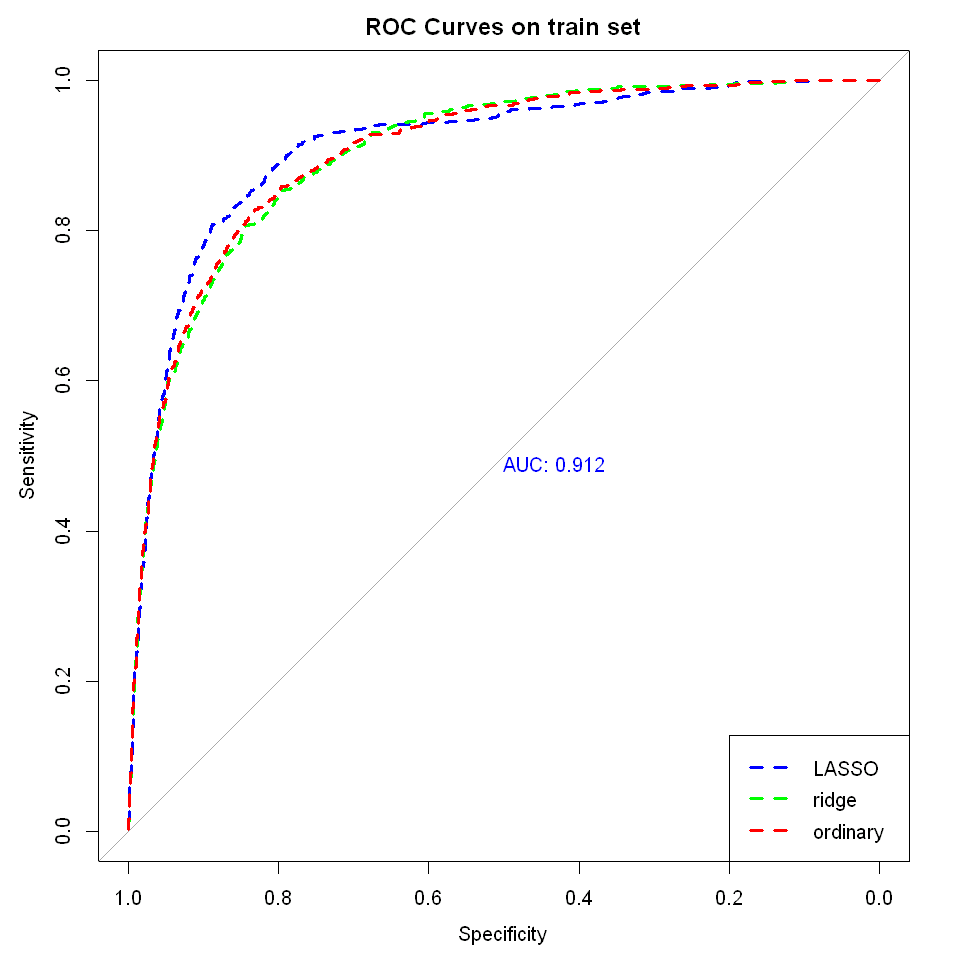

In [20]:
options(repr.plot.width = 8, repr.plot.height = 8)
ROC_lasso <- 
    roc(
        response = training$Revenue,
        predictor = predict(final_lasso,
                     newx = model_X_train)[,"s0"] ) 
ROC_ridge <- 
    roc(
        response = training$Revenue,
        predictor = predict(final_ridge,
                     newx = model_X_train)[,"s0"] ) 

ROC_prelim <- 
    roc(
        response = training$Revenue,
        predictor = predict(model,
                     newdata = training) ) 

# plot ROC curve
plot(ROC_lasso, print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "ROC Curves on train set")
lines.roc(ROC_ridge, print.auc = TRUE, col = "green", lwd = 3, lty = 2)
lines.roc(ROC_prelim, print.auc = TRUE, col = "red", lwd = 3, lty = 2)
legend("bottomright", legend = c("LASSO", "ridge", "ordinary"),
       col = c("blue", "green", "red"),
       lwd = 3, lty = 2)

From the above results of the training stage, we can see the LASSO model has highest AUC (0.912), indicating that it can dstinguish between the positive (have purchase) and negative (no puchase) class the best. Yet, the sensitivity (0.392) and balanced accuracy (0.685) are lower than that of ridge or ordinary model, which is within expectation due to severe class imbalance.

As noted in EDA, since the classes are highly imbalanced, we will use AUC as the selection metric since this does not depend on the threshold probability. Therefore, our final model is chosen to be the *LASSO model*.

#### **2.4.5 Final model evaluation**

Let us first look at the non-zero coefficients of the LASSO model:

In [21]:
coef <- coef(final_lasso)

coef_df <- data.frame(Predictor = rownames(coef),
                      Coefficient = as.numeric(coef))

coef_df %>% filter(Coefficient != 0)
cat("Table 1: Non-zero Coefficients of final LASSO model")

Predictor,Coefficient
<chr>,<dbl>
(Intercept),-2.15652472
ExitRates,-1.11846886
PageValues,0.05415008
MonthNov,0.10073973


Table 1: Non-zero Coefficients of final LASSO model

Only three variables were chosen in the end: `ExitRates`, `PageValues`, and `MonthNov`. Interestingly, `ExitRates` lower the log likelihood (and probability) of a purchase in a session.

As stated in training stage, we will use a threshold probability of 0.3 to address class imbalance. Looking at other metrics:

In [22]:
# Preparing X and y of test set for glmnet
model_X_test <- 
    model.matrix(object = Revenue ~ .,
                 data = testing)[, -1]

testing$Revenue <- as.numeric(testing$Revenue)

matrix_Y_test <- 
    as.matrix(testing$Revenue, ncol = 1)

In [23]:
# Predict probabilities on the test set

p_0 <- 0.3  # Threshold at 0.3

pred_lasso <-  ifelse(predict(final_lasso, model_X_test, type="response") >= p_0, 1, 0)

# Check the performance of the final model on test set using confusion matrix
conf_mat_lasso_test <- 
    confusionMatrix(
    data = as.factor(pred_lasso),
    reference = as.factor(matrix_Y_test),
    positive = "1"
)
conf_mat_lasso_test

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1881  213
         1   43  129
                                          
               Accuracy : 0.887           
                 95% CI : (0.8733, 0.8998)
    No Information Rate : 0.8491          
    P-Value [Acc > NIR] : 9.723e-08       
                                          
                  Kappa : 0.446           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.37719         
            Specificity : 0.97765         
         Pos Pred Value : 0.75000         
         Neg Pred Value : 0.89828         
             Prevalence : 0.15093         
         Detection Rate : 0.05693         
   Detection Prevalence : 0.07590         
      Balanced Accuracy : 0.67742         
                                          
       'Positive' Class : 1               
                        

**Table 2: confusion matrix and key metrics for LASSO Model on Test Set**

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Figure 3: ROC curve of LASSO Model on Test Set



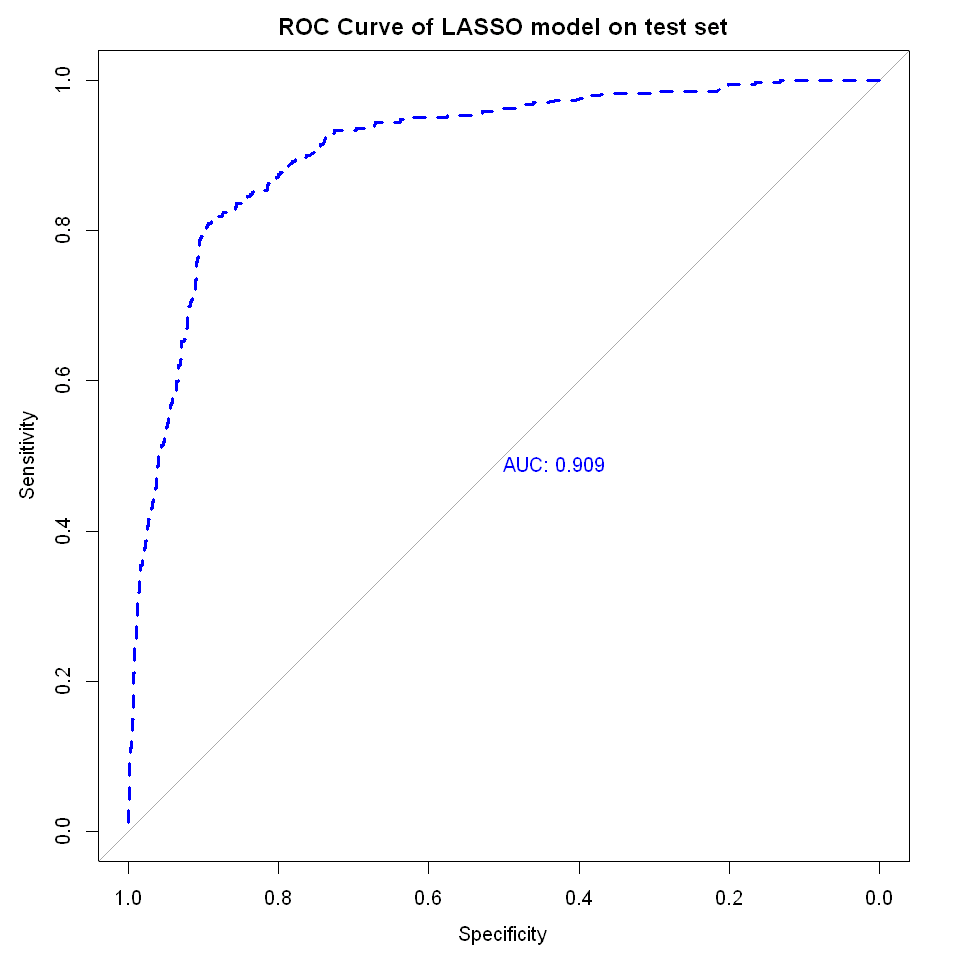

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)

# plot ROC curve
ROC_lasso_test <- 
    roc(
        response = testing$Revenue,
        predictor = predict(final_lasso,
                     newx = model_X_test)[,"s0"] ) 

plot(ROC_lasso_test, print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "ROC Curve of LASSO model on test set")
cat("Figure 3: ROC curve of LASSO Model on Test Set\n\n")

Looking at Table 2, we can see that if we always predicted the majority class, we would already get 85% accuracy, so accuracy is not a good evaluation metric. Our final LASSO model has:
- AUC: 0.909
- Sensitivity: 0.377
- Balanced accuracy: 0.677

Although the AUC is high, sensitivity and balanced accuracy are quite low. This result is expected because of class imbalance issues.

## **3 Discussion**

### **3.1 Findings and Expectations of the Model**
Overall, the LASSO model we built obtained an AUC of 0.909, which indicates it can perform classification fairly well across all possible threshold probabilities. However, we think the model is still not very strong since it cannot capture true positives well (sensitivity: 37.7%). The high accuracy (88.7%) is mainly driven by the fact that most sessions do not end in a purchase, so a model that predicts “no purchase” most of the time can already achieve a fairly high accuracy of 85%, even though it is not very helpful in practice. In particular, the LASSO model either miss many true purchases or create many false positives, which means they do not give a reliable balance between the two classes.

Interestingly, `ExitRates` lowers the log likelihood (and probability) of a purchase in a session.

The timing of session, excluding the month November, is shown to have weaker associations with the probability of a purchase. Webpage information also showed limited predictive power.
On the other hand, whether the session is in November (`Month` feature), and some webpage numeric metrics such as `ExitRates` and `PageValues` are strong predictors for a purchase. Some of our interested variables such as `Weekend` and `ProductRelated_Duration` are removed from the model, indicating they were not a strong predictor for the log likelihood of a purchase. Although we expected that `ProductRelated_Duration` had an association with the response, overall, the final model matches with our expectation in EDA.

### **3.2 Possible Improvements to the Model**
One way to improve this in future work is to use a weighted sample, by giving more weight to the positive class (have purchased) so that the model “pays more attention” to this minority class during training. Another way is to use alternative evaluation criteria, such as the F1 score or balanced accuracy, when choosing the model and the probability cutoff. Additionally, we could explore resampling strategies such as upsampling the minority class or downsampling the majority class to create a more balanced training set. These adjustments may lead to a model that better capture purchasing behaviour and provide more useful signals for identifying sessions that are likely to end in a purchase.

### **3.3 Future Directions for Study**
Since the dataset has severe class imbalance, we can see if applying the improvements stated in *Section 3.2* can improve the performance for the minority class (have purchased, `Revenue`=1).

Another direction is exploring other models, such as RandomForest or XGBoost, and compare the performance of these models to the LASSO model in this study. We can also try some data transformations such as using polynomial basis or interaction terms and see if these could improve prediction performance.

## 4 **References**

Data: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset